In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageH

In [4]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "bias": {}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [5]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*20, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    #"aberrations": opt(g*100,20),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
    "bias": opt(g*30, 20)
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [6]:
losses, models = optimise(params, model_single, exposures_single, things, 30)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[[4122117.2 -679866.8]
 [-679867.  4092691.2]]
[[39825768.     -395630.62  14555066.     -203756.88   9614282.   ]
 [ -395632.56   4865412.5    -219794.56   3096979.2    -170935.62 ]
 [14555066.     -219794.     6592661.5    -130512.375  4699113.   ]
 [ -203758.06   3096979.2    -130512.75   2330051.8    -104022.56 ]
 [ 9614284.     -170935.38   4699112.5    -104022.31   3518412.5  ]]
[[-80787.086   9609.007]
 [  9609.009 -80638.23 ]]
[[-145900.92]]
[[8218082.]]
{'n8yj59glq': {'positions': Array([[4122117.2, -679866.8],
       [-679867. , 4092691.2]], dtype=float32), 'spectrum': Array([[39825768.   ,  -395630.62 , 14555066.   ,  -203756.88 ,
         9614282.   ],
       [ -395632.56 ,  4865412.5  ,  -219794.56 ,  3096979.2  ,
         -170935.62 ],
       [14555066.   ,  -219794.   ,  6592661.5  ,  -130512.375,
         4699113.   ],
       [ -203758.06 ,  3096979.2  ,  -130512.75 ,  2330051.8  ,
         -104022.56 ],
       [ 9614284.   ,  -170935.38 ,  4699112.5  ,  -104022.31 ,
  

  0%|          | 0/30 [00:00<?, ?it/s]

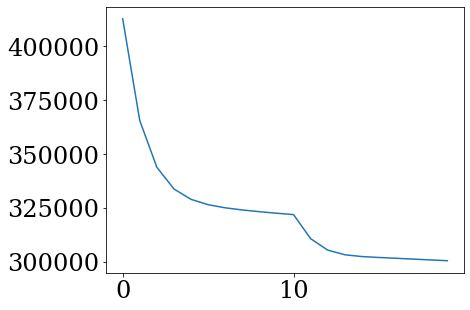

In [7]:
plt.plot(losses[-20:])

5


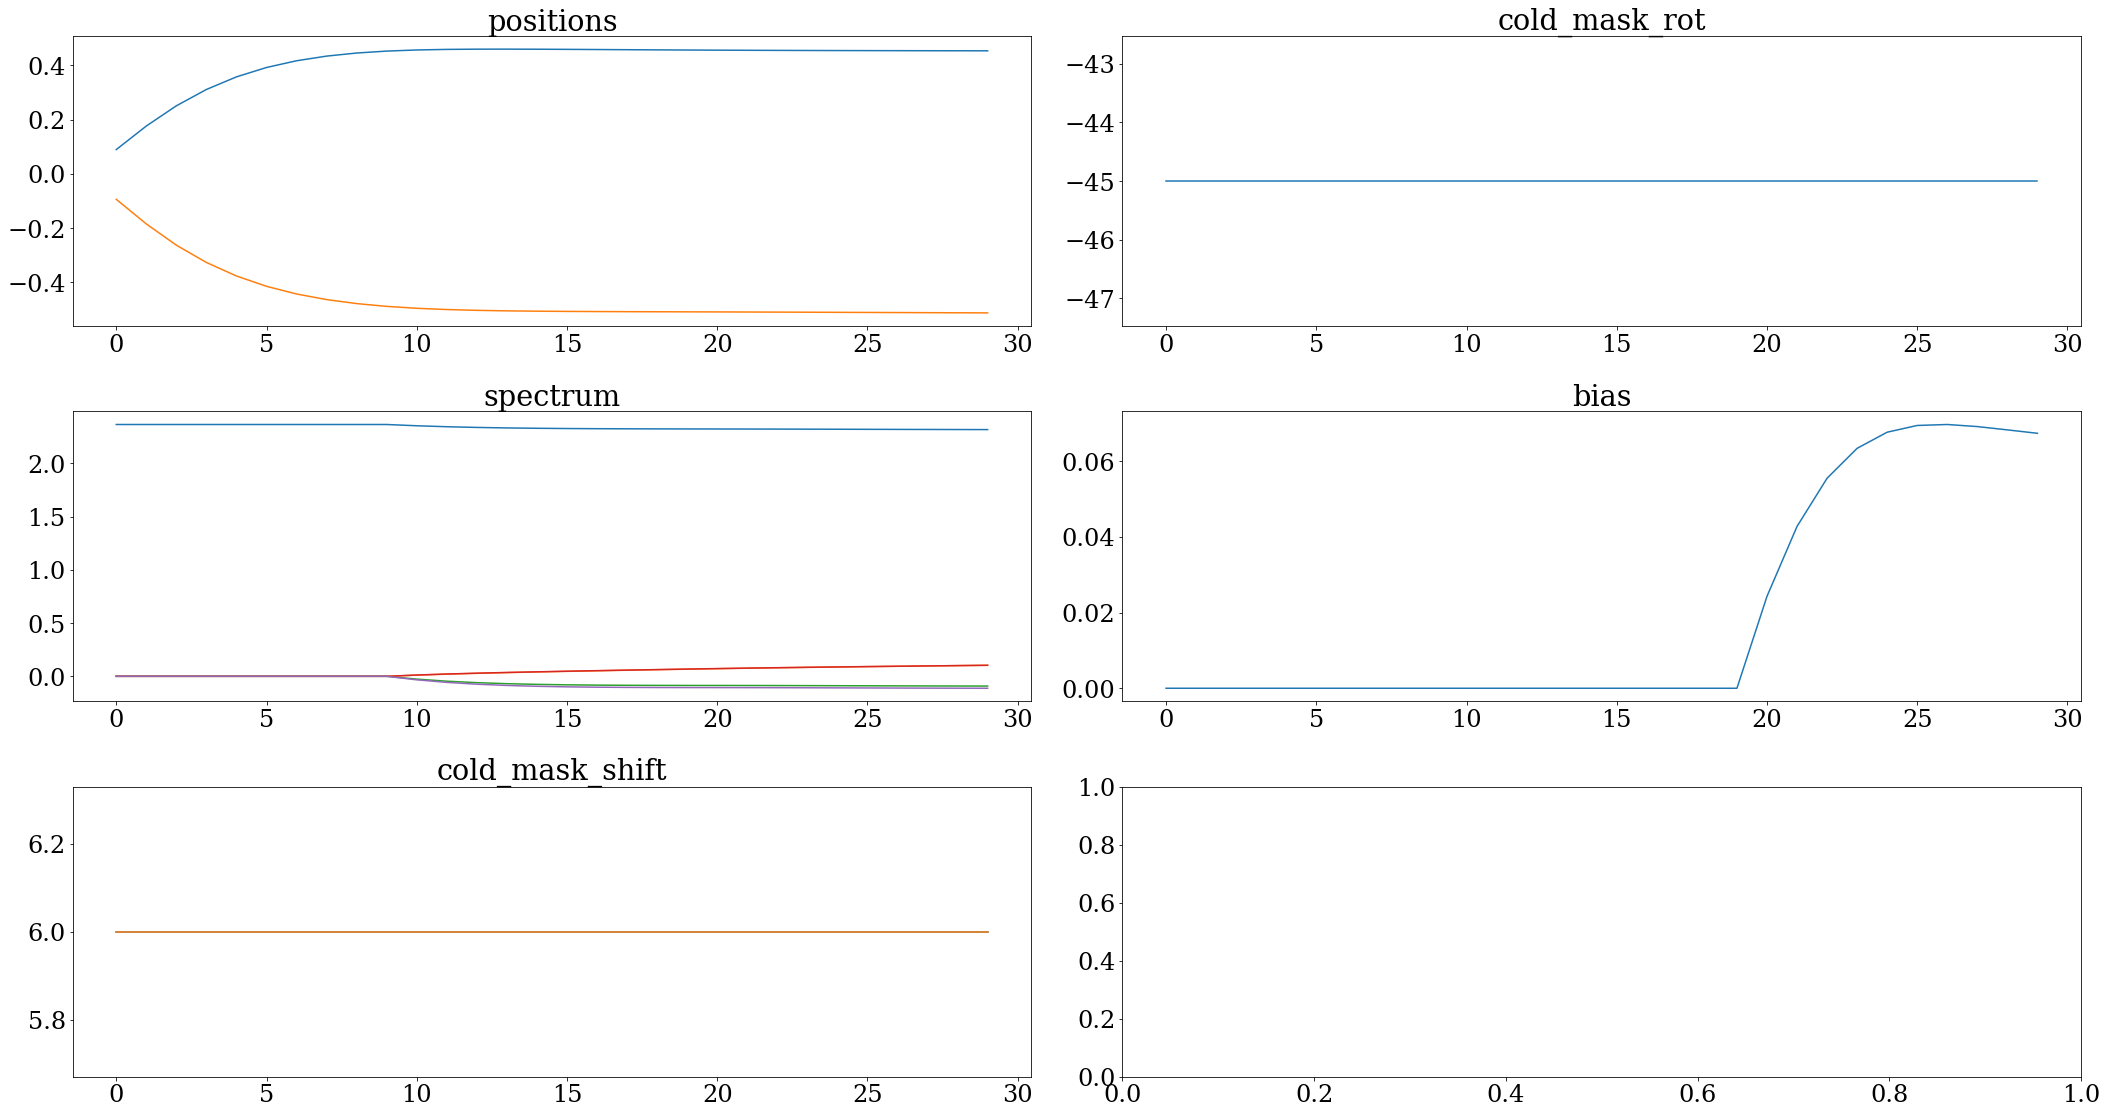

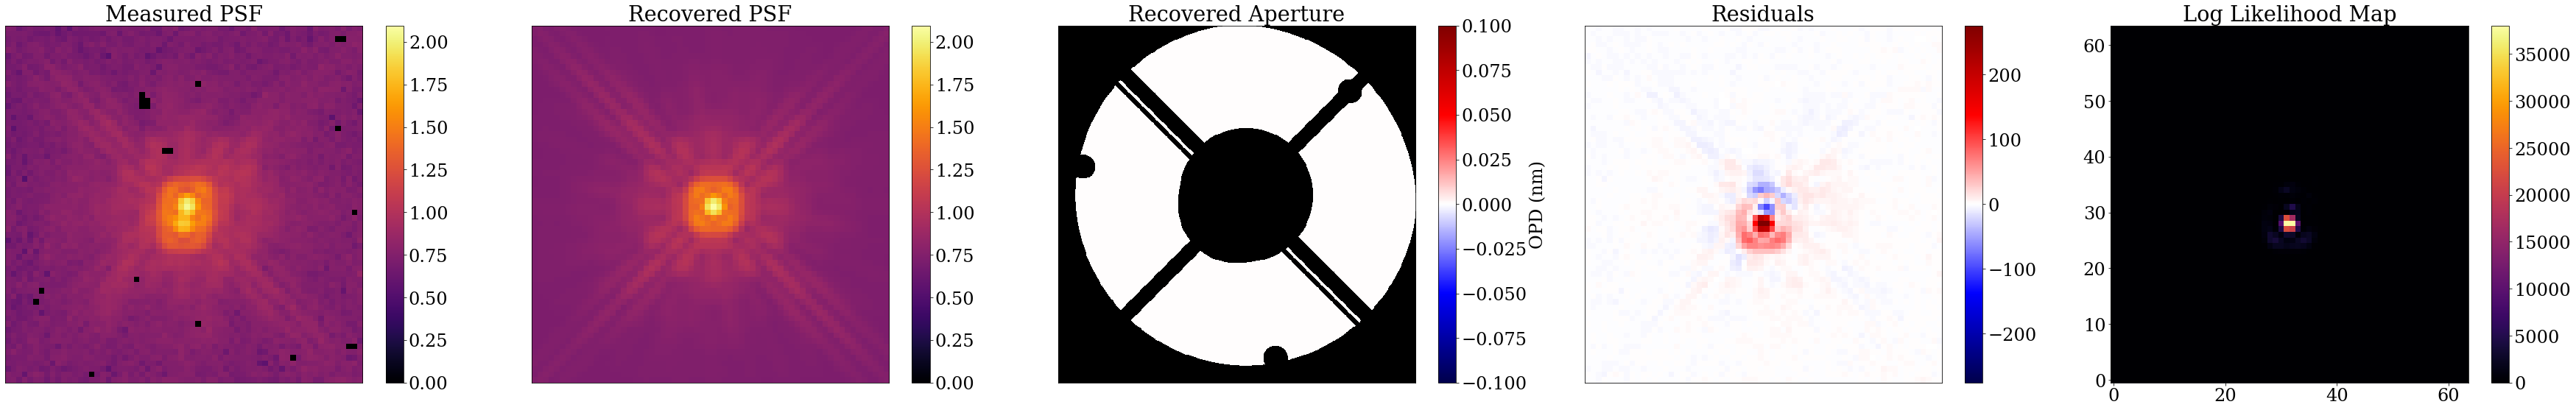

In [8]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [9]:
#potato

In [10]:
#plot_spectra(model_single, models[-1], exposures_single)

In [11]:
def tree_mul(spec, val):
    return jtu.tree_map(lambda x: x*val, spec)

def tree_sum(spec, val):
    return jtu.tree_map(lambda x: x+val, spec)


def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = tree_sum(param_dict["positions"], np.array([x,y]))
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)


"""def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):
    fluxes = dlu.fluxes_from_contrast(flux, contrast)
    injected_params = ModelParams({
        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),
        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),
        "positions": np.asarray([x,y]),
        "position_angle": theta,
        "separation": r
    })
    return injected_params.inject(initial_params)
"""

'def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):\n    fluxes = dlu.fluxes_from_contrast(flux, contrast)\n    injected_params = ModelParams({\n        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),\n        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),\n        "positions": np.asarray([x,y]),\n        "position_angle": theta,\n        "separation": r\n    })\n    return injected_params.inject(initial_params)\n'

In [12]:
binary_params = extract_binary_params(models[-1], exposures_binary, 0., 0., 0., 0., 0., 1.)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [13]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [14]:
#things = {"primary_spectrum": opt(4e-6, 0), "secondary_spectrum": opt(4e-6, 0)}#, "contrast": opt(1e-8, 10)}
things = {"fluxes": opt(5e-11, 0)}#, "contrast": opt(5e-11, 10)}

@zdx.filter_jit
@zdx.filter_value_and_grad(list(things.keys()))
def binary_loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

def binary_optimise(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]
    
    optim, opt_state = zdx.get_optimiser(
        params, paths, optimisers
    )

    losses, models = [], []
    for i in (range(niter)):
        loss, grads = binary_loss_fn(params,exposures, model)
        #grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
        updates, opt_state = optim.update(grads, opt_state)
        params = zdx.apply_updates(params, updates)

        models.append(params)
        losses.append(loss)
    
    return losses, models

In [15]:
binary_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'bias':
    {'n8yj59glq': f32[]},
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'outer_radius':
    1.146,
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924,
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'fluxes':
    {'U20081_F110W': 0.0},
    'contrast':
    {'F110W': 1.0},
    'separation':
    0.0,
    'position_angle':
    0.0
  }
)

In [16]:
x_vals = np.linspace(-5, 5, 4)
y_vals = np.linspace(-5, 5, 4)
theta_vals = np.arange(4)*np.pi/2#np.linspace(0, 2*np.pi, 4)
r_vals = np.asarray([1.5, 3])#np.linspace(0, 5, 2)

min_loss = np.inf
best_params = None

for x in x_vals:
    for y in y_vals:
        for theta in theta_vals:
            for r in r_vals:
                binary_params = extract_binary_params(models[-1], exposures_binary, x, y, theta, r, 0., 1.)
                #binary_params = extract_binary_params(models[-1], exposures_binary, 0, 0, 0, 0, 0., 1.)#np.log10(0.5), 1.)
                losses, bms = binary_optimise(binary_params, model_binary, exposures_binary, things, 10)
                print(losses[-1])
                if losses[-1] < min_loss and min_loss != 0.0:
                    min_loss = losses[-1]
                    best_params = bms[-1]
                

29739654.0
29254984.0
29746006.0
29304344.0
29752954.0
29355122.0
29760458.0
29406764.0
26370598.0
25773256.0
26362910.0
25744536.0
26356560.0
25725740.0
26351550.0
25716860.0
29810230.0
29394086.0
29809888.0
29379636.0
29810080.0
29366416.0
29810838.0
29354638.0
29196642.0
30482892.0
29183148.0
30458756.0
29169474.0
30433104.0
29155668.0
30406006.0
20336010.0
17542128.0
20307806.0
17449790.0
20280052.0
17358580.0
20252832.0
17268676.0
8590417.0
5797398.5
8565268.0
5737103.0
8540883.0
5680953.5
8517352.0
5629303.5
16314146.0
14298061.0
16357841.0
14450368.0
16400891.0
14602261.0
16443150.0
14753167.0
30595462.0
30545452.0
30594368.0
30537068.0
30593226.0
30528514.0
30592008.0
30519838.0
21248762.0
18687210.0
21262792.0
18698422.0
21277704.0
18712238.0
21293434.0
18728704.0
11883355.0
8465606.0
11898793.0
8512914.0
11914218.0
8561210.0
11929600.0
8610435.0
15137254.0
12361764.0
15091572.0
12192960.0
15046443.0
12028099.0
15002005.0
11867580.0
29899390.0
29593542.0
29901008.0
29594452.0


In [17]:
best_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'bias':
    {'n8yj59glq': f32[]},
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f32[]},
    'outer_radius':
    1.146,
    'position_angle':
    f32[],
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'separation':
    f32[],
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924
  }
)

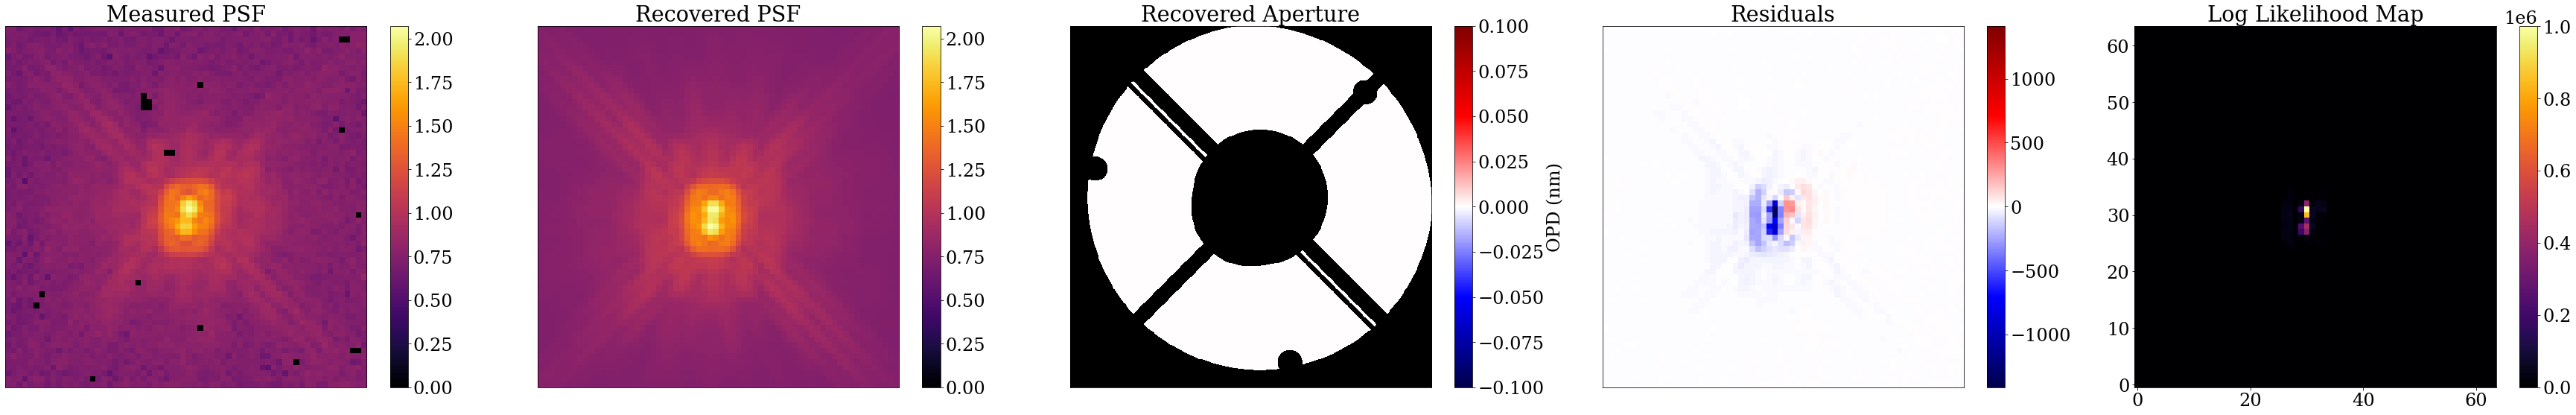

In [18]:
plot_comparison(model_binary, best_params, exposures_binary)

In [28]:
g = 5e-3
things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*100, 0),
    "separation": opt(g*30, 0),
    "position_angle": opt(g*1e-2, 10),
    "primary_spectrum": opt(g*50, 20),
    "secondary_spectrum": opt(g*50, 20),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 60),
    "cold_mask_rot": opt(g*10, 60),
    "aberrations": opt(g*10,30),#, (150, g*0.2)),
    "bias": opt(g*20, 40)
}
groups = list(things.keys())


In [29]:
losses, models = optimise(best_params, set_array(model_binary), exposures_binary, things, 150)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[[6871715.   -300683.72]
 [-300683.66 5537492.5 ]]
[[-404701.28]]
[[0.]]
[[27911078.    2834154.    9142960.    2015467.5   5739311.5 ]
 [ 2834154.    5051256.5   1458631.2   3119766.    1090050.  ]
 [ 9142959.    1458630.9   4389850.    1137516.6   3145345.8 ]
 [ 2015467.2   3119766.    1137516.5   2331080.8    905450.75]
 [ 5739311.5   1090049.8   3145346.2    905451.    2435793.5 ]]
[[27911078.    2834154.    9142960.    2015467.5   5739311.5 ]
 [ 2834154.    5051256.5   1458631.2   3119766.    1090050.  ]
 [ 9142959.    1458630.9   4389850.    1137516.6   3145345.8 ]
 [ 2015467.2   3119766.    1137516.5   2331080.8    905450.75]
 [ 5739311.5   1090049.8   3145346.2    905451.    2435793.5 ]]
[[-189148.5     21709.78 ]
 [  21709.777 -189099.86 ]]
[[-337550.5]]
[[-6.38052025e+01  7.14069462e+00 -1.93706360e+01  2.91777916e+01
  -3.15872345e+01  1.43267097e+01  4.16942930e+00  2.13388443e+00
  -3.06062984e+00 -1.10530653e+01 -1.30156130e-01  1.15052385e+01
  -4.81943130e+01  4.5158153

  0%|          | 0/150 [00:00<?, ?it/s]

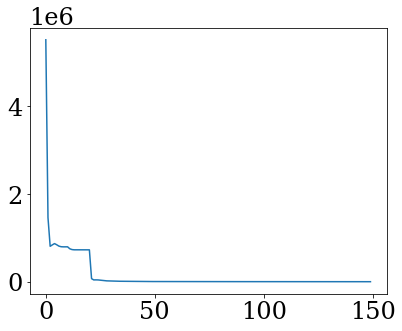

In [30]:
plt.plot(losses)

In [33]:
losses[-1]

Array(2222.0742, dtype=float32)

9


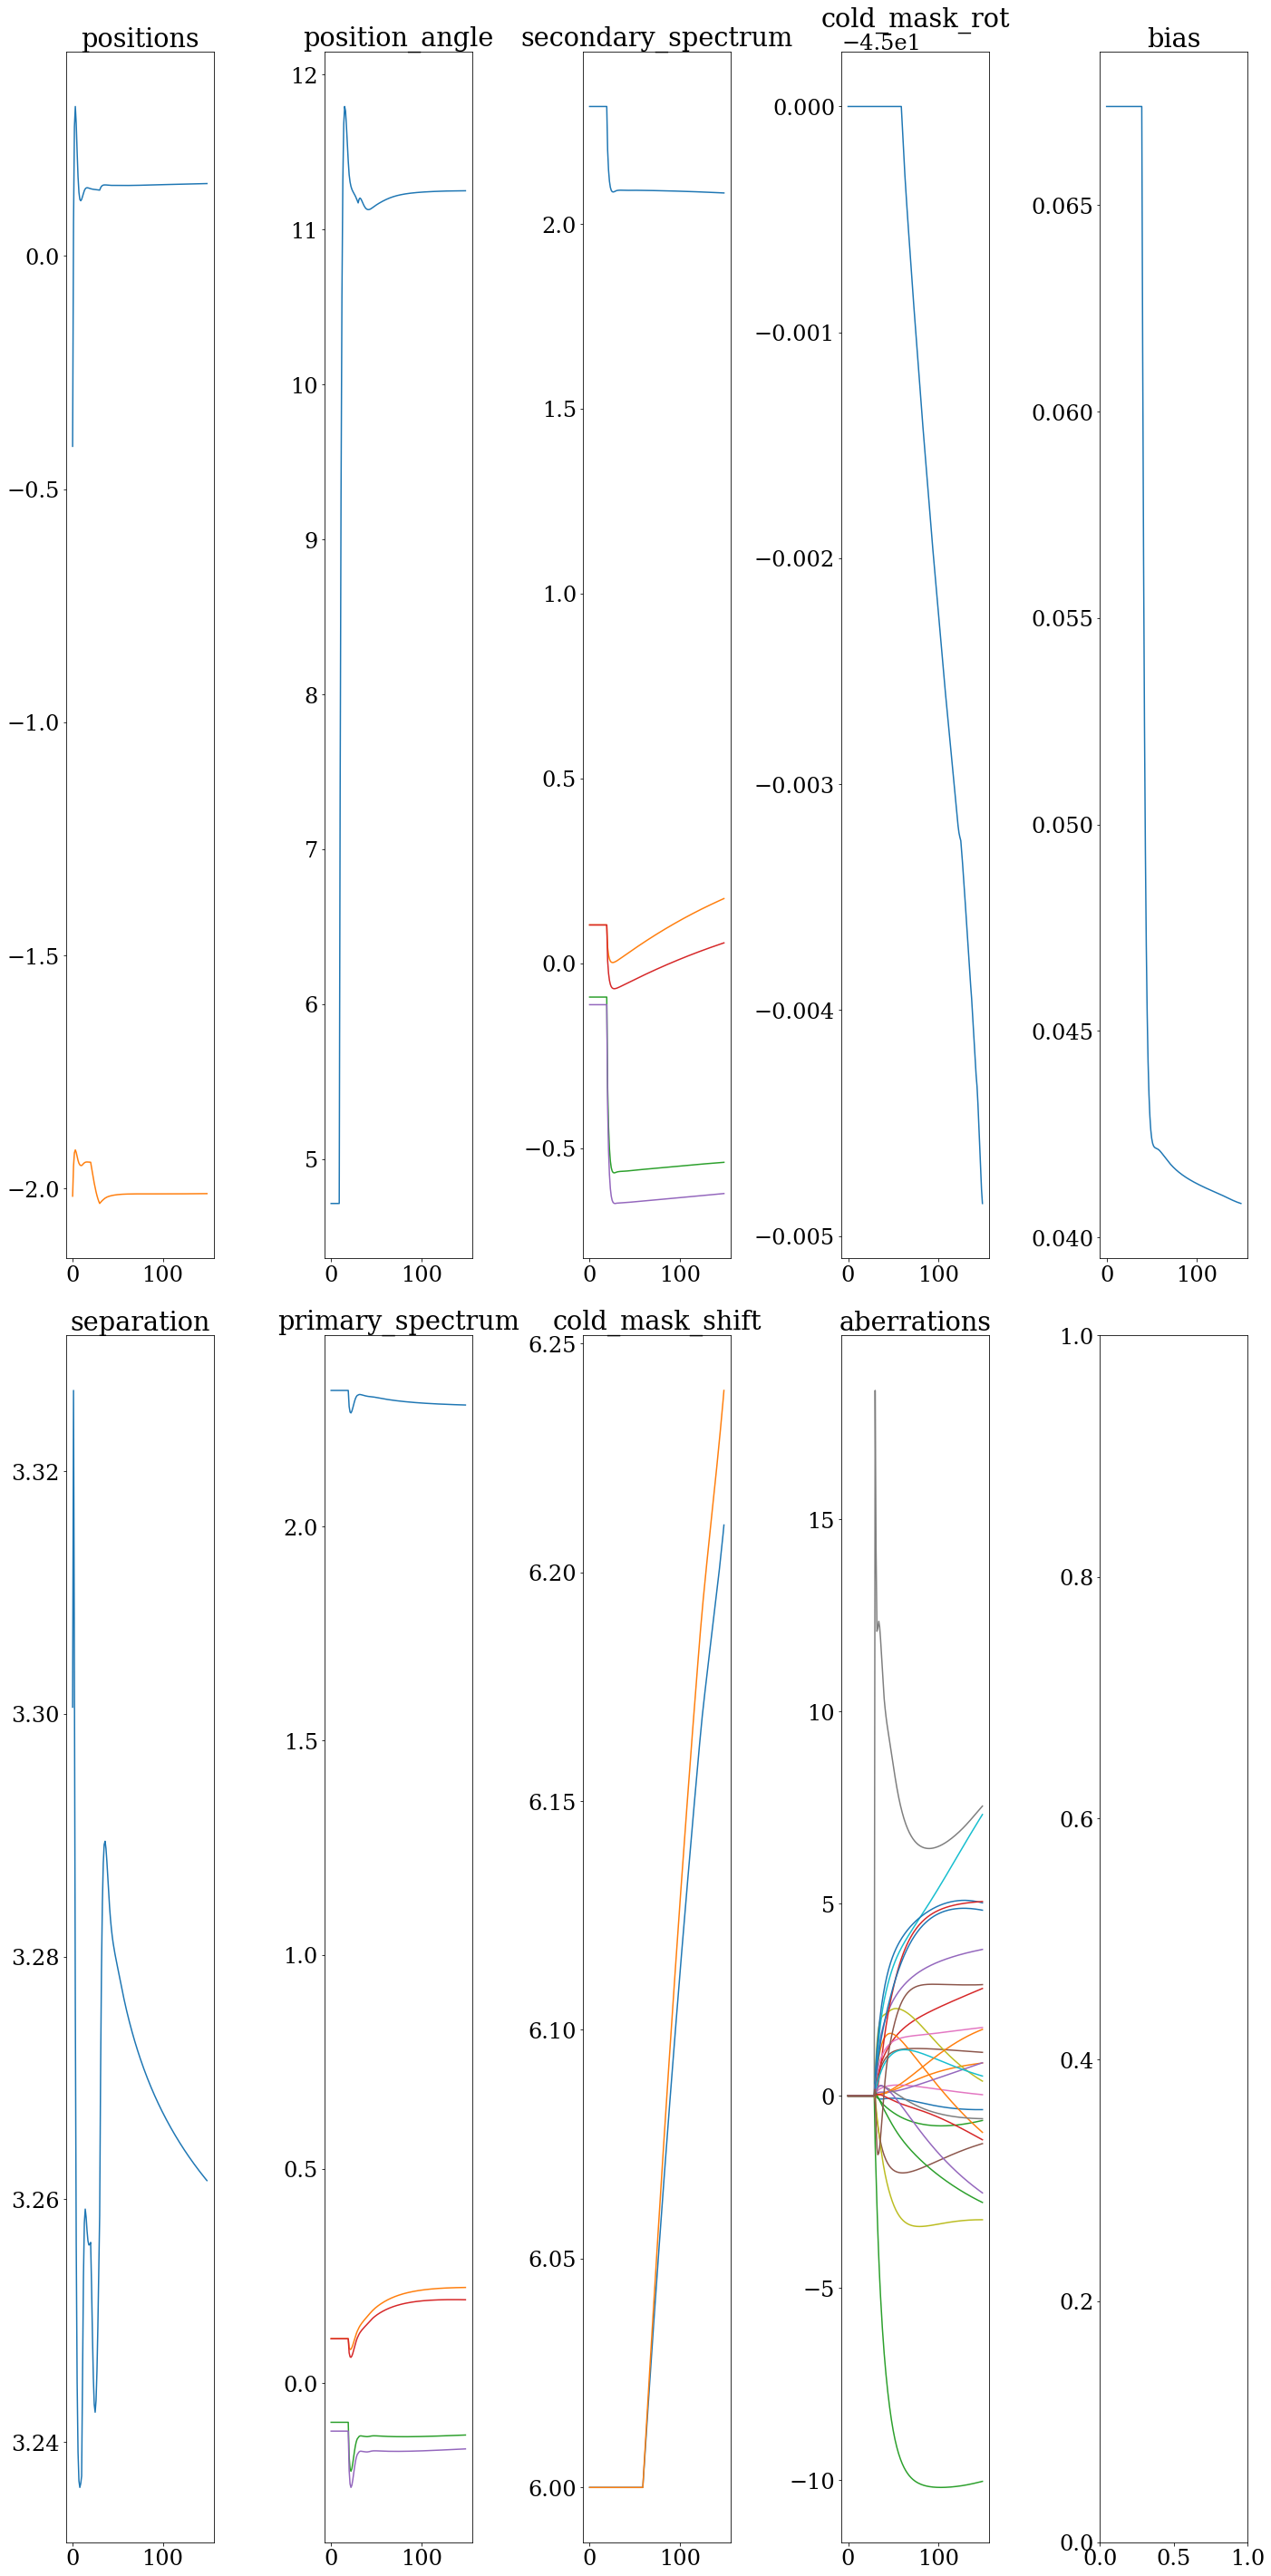

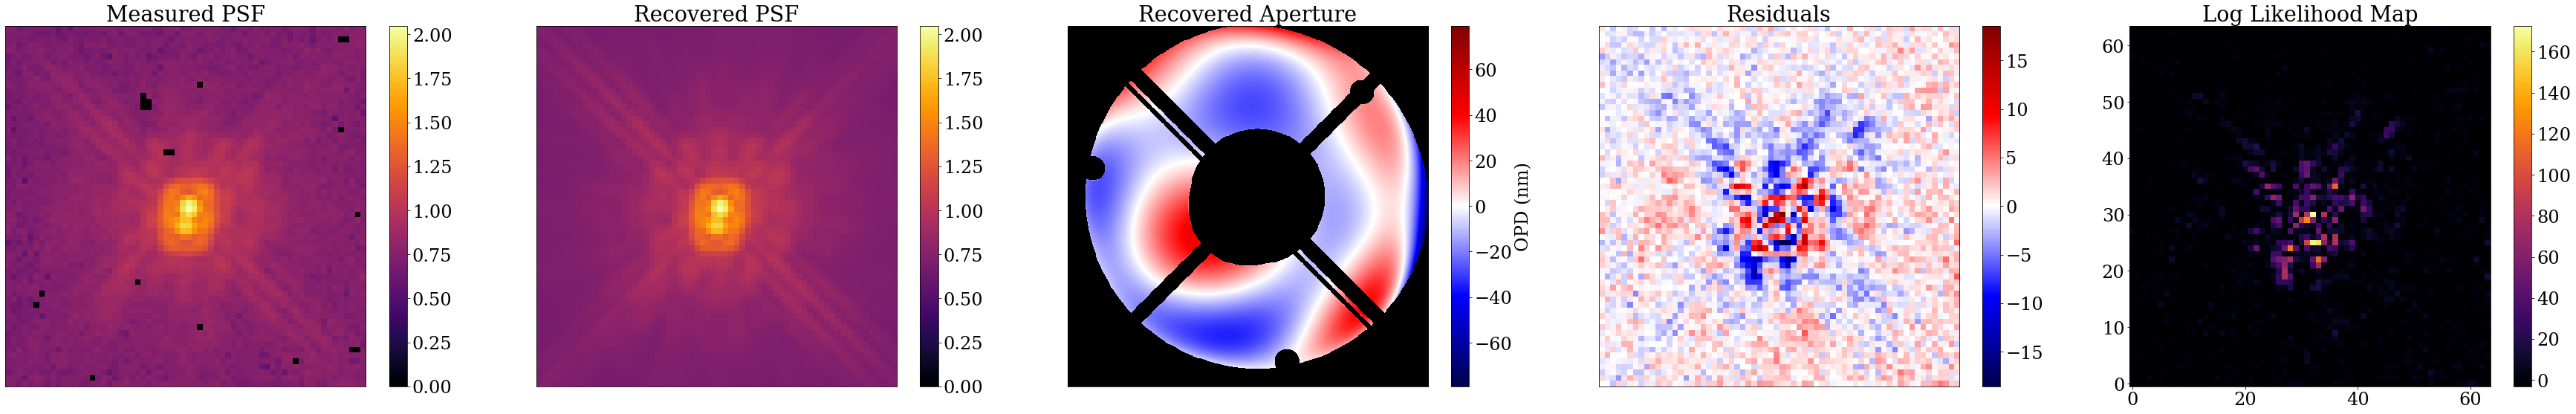

In [31]:
plot_params(models, groups, xw = 2)
plot_comparison(model_binary, models[-1], exposures_binary)

In [34]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ -0.3574974 ,   0.85564387,  -0.63937044,   2.7948685 ,
           3.8113282 ,   1.1332598 ,   0.0315538 ,   7.540781  ,
           0.38446912,   7.3207936 ,   5.023941  ,  -0.94839716,
         -10.029183  ,   5.058091  ,   0.86185247,  -1.2414627 ,
           1.7790534 ,  -0.5930939 ,  -3.222159  ,   0.516796  ,
           4.831683  ,   1.7295856 ,  -2.7724073 ,  -1.1411949 ,
          -2.5236504 ,   2.895551  ], dtype=float32)},
 'bias': {'n8yj59glq': Array(0.04081931, dtype=float32)},
 'cold_mask_rot': {'F110W': Array(-45.004856, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj59glq': Array([6.2103186, 6.239728 ], dtype=float32)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.0372237, dtype=float32))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.250632, dtype=float32),
 

Text(0, 0.5, 'Relative Spectral Intensity')

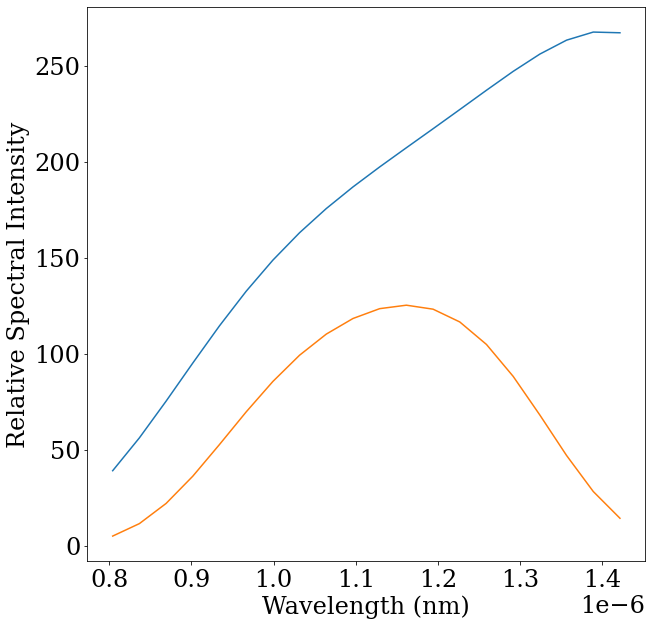

In [35]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [36]:
rc = True
fishers = calc_fishers(models[-1].inject(model_binary), exposures_binary, groups, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[[1912828.2   -71727.18]
 [ -71727.19 1667554.6 ]]
[[455199.06]]
[[1523.4326]]
[[10325227.    2390556.5   3526384.5   1594602.    2257531.  ]
 [ 2390555.8    767876.6    862876.25   469321.38   553847.9 ]
 [ 3526384.     862876.5   1230178.6    569388.4    788882.25]
 [ 1594601.5    469321.44   569388.3    294757.44   365669.25]
 [ 2257530.8    553848.1    788882.25   365669.3    506166.47]]
[[3150694.2     200804.98    585936.75     97049.86    257817.8   ]
 [ 200805.       42819.996    37105.273    15526.532    16195.896 ]
 [ 585936.94     37105.3     110233.71     17195.354    48506.73  ]
 [  97049.87     15526.534    17195.35      5845.6265    7204.362 ]
 [ 257817.78     16195.894    48506.72      7204.3604   21325.242 ]]
[[731.6719  307.95605]
 [307.95605 962.28485]]
[[3059.1802]]
[[ 7.67876434e+00 -2.45014262e+00  3.60960305e-01  9.57092881e-01
  -1.14442182e+00  1.18705058e+00  2.30396748e+00  6.55469608e+00
   6.64850920e-02 -3.60659409e+00  3.16902661e+00  7.07948327e-01
  -4.

In [37]:
fishers

{'n8yj59glq': {'positions': Array([[1912828.2 ,  -71727.18],
         [ -71727.19, 1667554.6 ]], dtype=float32),
  'separation': Array([[455199.06]], dtype=float32),
  'position_angle': Array([[1523.4326]], dtype=float32),
  'primary_spectrum': Array([[10325227.  ,  2390556.5 ,  3526384.5 ,  1594602.  ,  2257531.  ],
         [ 2390555.8 ,   767876.6 ,   862876.25,   469321.38,   553847.9 ],
         [ 3526384.  ,   862876.5 ,  1230178.6 ,   569388.4 ,   788882.25],
         [ 1594601.5 ,   469321.44,   569388.3 ,   294757.44,   365669.25],
         [ 2257530.8 ,   553848.1 ,   788882.25,   365669.3 ,   506166.47]],      dtype=float32),
  'secondary_spectrum': Array([[3150694.2   ,  200804.98  ,  585936.75  ,   97049.86  ,
           257817.8   ],
         [ 200805.    ,   42819.996 ,   37105.273 ,   15526.532 ,
            16195.896 ],
         [ 585936.94  ,   37105.3   ,  110233.71  ,   17195.354 ,
            48506.73  ],
         [  97049.87  ,   15526.534 ,   17195.35  ,    5845.

In [38]:
aberration_names = [dlu.zernike_name(x) for x in range(40)]
poly_names = ["poly "+ x for x in ["0", "1", "2", "3", "4"]]

In [39]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ -0.3574974 ,   0.85564387,  -0.63937044,   2.7948685 ,
           3.8113282 ,   1.1332598 ,   0.0315538 ,   7.540781  ,
           0.38446912,   7.3207936 ,   5.023941  ,  -0.94839716,
         -10.029183  ,   5.058091  ,   0.86185247,  -1.2414627 ,
           1.7790534 ,  -0.5930939 ,  -3.222159  ,   0.516796  ,
           4.831683  ,   1.7295856 ,  -2.7724073 ,  -1.1411949 ,
          -2.5236504 ,   2.895551  ], dtype=float32)},
 'bias': {'n8yj59glq': Array(0.04081931, dtype=float32)},
 'cold_mask_rot': {'F110W': Array(-45.004856, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj59glq': Array([6.2103186, 6.239728 ], dtype=float32)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.0372237, dtype=float32))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.250632, dtype=float32),
 

In [40]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0]

Array(0.02562054, dtype=float32)

In [41]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0]

Array(0.00148217, dtype=float32)

In [42]:
np.diag(np.sqrt(np.linalg.inv(fishers['n8yj59glq']['secondary_spectrum'])))

Array([0.0056024 , 0.00794905, 0.06240182, 0.01476297, 0.07598587],      dtype=float32)

In [43]:
#potato

In [ ]:

def make_psf_model(modelparams, fishers):

    #@zdx.filter_jit
    def psf_model(data, model):

        params = {
            "primary_spectrum": {},
            "secondary_spectrum": {},
            "positions": {},
            #"position_angle": 0., 
            #"separation": 0. , 
            #"cold_mask_shift": {},
            #"aberrations": {},
        }

        for exp in exposures_binary:
            #params["fluxes"][exp.fit.get_key(exp, "fluxes")] = npy.sample("Flux", dist.Normal(0,1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj53vfq']['fluxes'])))[0][0] + modelparams.get(exp.map_param("fluxes"))
            """
            params["position_angle"] = npy.sample("Position Angle", dist.Normal(modelparams.get("position_angle"), 1))

            params["separation"] = npy.sample("Separation", dist.Normal(modelparams.get("separation"), 1))

            #params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([npy.sample("Cold X", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[0][0] + modelparams.get(exp.map_param("cold_mask_shift"))[0], npy.sample("Cold Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[1][1] + modelparams.get(exp.map_param("cold_mask_shift"))[1]])
            
            params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([npy.sample("X", dist.Normal(modelparams.get(exp.map_param("positions"))[0], 1)), npy.sample("Y", dist.Normal(modelparams.get(exp.map_param("positions"))[1], 1))])

            params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")] = np.asarray([
                npy.sample("primary "+poly_names[x], dist.Normal(modelparams.get(exp.map_param("primary_spectrum"))[i],1)) for i, x in enumerate(range(0,5))
                
            ])

            params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")] = np.asarray([
                npy.sample("secondary " + poly_names[x], dist.Normal(modelparams.get(exp.map_param("secondary_spectrum"))[i] ,1)) for i, x in enumerate(range(0,5))
                
            ])"""

                        #params["fluxes"][exp.fit.get_key(exp, "fluxes")] = npy.sample("Flux", dist.Normal(0,1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj53vfq']['fluxes'])))[0][0] + modelparams.get(exp.map_param("fluxes"))

            params["position_angle"] = npy.sample("Position Angle", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0] + modelparams.get("position_angle")

            params["separation"] = npy.sample("Separation", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0] + modelparams.get("separation")

            #params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([npy.sample("Cold X", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[0][0] + modelparams.get(exp.map_param("cold_mask_shift"))[0], npy.sample("Cold Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[1][1] + modelparams.get(exp.map_param("cold_mask_shift"))[1]])
            
            params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([npy.sample("X", dist.Normal(0,1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['positions'])))[0][0] + modelparams.get(exp.map_param("positions"))[0], npy.sample("Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['positions'])))[1][1] + modelparams.get(exp.map_param("positions"))[1]])

            params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")] = np.asarray([
                npy.sample("primary "+poly_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['primary_spectrum'][i][i]) + modelparams.get(exp.map_param("primary_spectrum"))[i] for i, x in enumerate(range(0,5))
                
            ])

            params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")] = np.asarray([
                npy.sample("secondary " + poly_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['secondary_spectrum'][i][i]) + modelparams.get(exp.map_param("secondary_spectrum"))[i] for i, x in enumerate(range(0,5))
                
            ])



            #params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([
            #    npy.sample(aberration_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['aberrations'][i][i]) + modelparams.get(exp.map_param("aberrations"))[i] for i, x in enumerate(range(4,30))
                
            #])

        params = ModelParams(params)

        
        
        with npy.plate("data", size=len(data.data.flatten())):

            mdl = params.inject(model)
            model_data = data.fit(mdl, data).flatten()
            img, err, bad = data.data.flatten(), data.err.flatten(), data.bad.flatten()
            image = np.where(bad, 0, img)
            error = np.where(bad, 1e5, err)
            
            image_d = dist.Normal(image, error)
            return npy.sample("psf", image_d, obs=np.where(bad,0,model_data))
    
    return psf_model



sampler = npy.infer.MCMC(
    npy.infer.NUTS(make_psf_model(models[-1], jtu.tree_map(lambda x: np.abs(x), fishers)), 
                   init_strategy=npy.infer.init_to_sample,
                    dense_mass=False),
    num_warmup=500,
    num_samples=500,
    #num_chains=6,
    #chain_method='vectorized',
    progress_bar=True,
    chain_method = zdx.filter_jit,
    #jit_model_args=True,
)

sampler.run(jr.PRNGKey(0),exposures_binary[0], model_binary)

sampler.print_summary()

chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="teal")
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
#fig.savefig("chains_hmc_data.png")
#plt.close()

plt.show()

warmup:   2%|▏         | 23/1000 [00:53<53:37,  3.29s/it, 7 steps of size 5.11e-04. acc. prob=0.65] 